In [1]:
import matplotlib.pyplot as plt
import geopandas
import contextily as ctx
import views
import views.apps.plot.maps as maps

In [2]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format=views.config.LOGFMT,
    handlers=[
        logging.StreamHandler(),
    ],
)
log = logging.getLogger(__name__)

In [3]:
mapdata = views.apps.plot.maps.MapData()

[2020-11-10 14:49:56,213] - views.apps.data.api:162 - INFO - Found gdf on file at /Users/rbjansen/github/OpenViEWS2/storage/data/geometries/country.geojson
[2020-11-10 14:49:57,220] - views.apps.data.api:211 - INFO - Found gdf on file at /Users/rbjansen/github/OpenViEWS2/storage/data/geometries/priogrid.geojson


In [4]:
gdf_pgm = views.GEOMETRIES["GeomPriogrid"].gdf
df_pg_c = views.TABLES["skeleton.pg_c"].df.rename(
    columns={"country_id": "geo_country_id"}
)
gdf_pgm.join(df_pg_c)

[2020-11-10 14:50:00,693] - views.apps.data.api:211 - INFO - Found gdf on file at /Users/rbjansen/github/OpenViEWS2/storage/data/geometries/priogrid.geojson


,geom,geo_country_id
pg_id,,
49182,"POLYGON ((-69.50000 -56.00000, -69.50000 -55.5...",10
49183,"POLYGON ((-69.00000 -56.00000, -69.00000 -55.5...",10
49184,"POLYGON ((-68.50000 -56.00000, -68.50000 -55.5...",10
49185,"POLYGON ((-68.00000 -56.00000, -68.00000 -55.5...",10
49186,"POLYGON ((-67.50000 -56.00000, -67.50000 -55.5...",10
...,...,...
249340,"POLYGON ((-70.50000 83.00000, -70.50000 83.500...",183
249341,"POLYGON ((-70.00000 83.00000, -70.00000 83.500...",183
249342,"POLYGON ((-69.50000 83.00000, -69.50000 83.500...",183


In [5]:
col = "decay_12_time_since_ged_dummy_ns"  # Example column.

In [6]:
df = views.DATASETS["pgm_africa_imp_0"].df[[col]]

### Using the mapper
As we've tried to ensure that old code remains compatible with the current mapper, `plot_map` comes with a few defaults that relate to predicted probabilities only. **Defaults are (currently) triggered when no `cmap` is explicitly provided.** In that case, `logodds=True` will give the labels for logodds and shift the rainbow map accordingly, while `logodds=False` sets the cbar up for general probabilties.

Note that if you do not want to plot with default settings, set a cmap and set logodds to False (you can of course also set logodds to True as long as the outcome is a probability).

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:title={'center':'2017-6'}>)

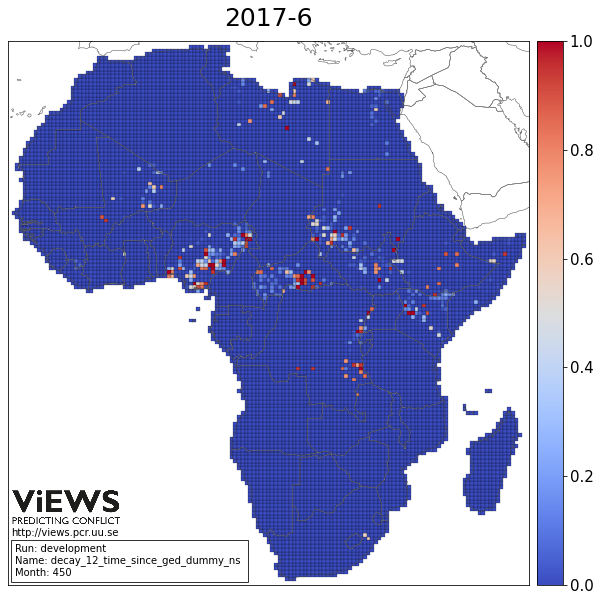

In [7]:
maps.plot_map(
    s_patch=df[col], 
    mapdata=mapdata, 
    cmap="coolwarm", 
    logodds=False, 
    t=450, 
    bbox="mainland_africa"
)

A lot of elements are adjustable. Please see the docstring for more details. 

Note that you can for instance set the tick values and labels, set a custom textbox over any number of lines, and pick a country_id:

In [ ]:
tick_values=[500, 1000, 1500]
maps.plot_map(
    s_patch=df[col].loc[450:451], 
    cmap="viridis_r", 
    mapdata=mapdata, 
    textbox="two-line\ncustom text", 
    logodds=False,
    #bbox="mainland_africa", # Disable this to zoom in on a country.
    tick_values=tick_values,
    tick_labels=[f"{i}!" for i in tick_values],
    country_id=70,
    bbox_pad=[-5, 3, -2, 1],
    title="Central African Republic at t"
)

If you want to plot simple markers for dummies of observed violence for instance, use `s_marker` (the resulting warning is a TODO):

In [ ]:
df = views.DATASETS["cm_africa_imp_0"].df[["wdi_vc_pkp_totl_un", "ged_dummy_sb"]]
fig, ax = maps.plot_map(
    s_patch=df["wdi_vc_pkp_totl_un"], 
    s_marker=df["ged_dummy_sb"],
    bbox_pad=[-5, 3, -2, 1], 
    mapdata=mapdata, 
    cmap="viridis", 
    logodds=False, 
    t=450,
    ymin=0,
    ymax=6,
    bbox="mainland_africa",
    size_cborder=0
)

Country and priogrid borders are integrated into the function (you can make them invisible by setting their size to 0). If you'd like to plot any other geographical information, simply plot into ax and then plot another layer.

This can be any shapefile/geojson/other sourced locally or from a url (note that you may need to subset it):

In [ ]:
df = views.DATASETS["pgm_africa_imp_0"].df[[col]]
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))
fig, ax = maps.plot_map(
    s_patch=df[col], 
    bbox_pad=[-5, 3, -2, 1], 
    mapdata=mapdata, 
    cmap="Blues", 
    logodds=False, 
    t=450,
    bbox="mainland_africa",
    size_cborder=0
)
cities.plot(color='red', ax=ax, zorder=1)  # You can place the layer in any z-order.

Or use contextily for basemaps, which uses imshow to put tiles in the background. Note that you'll need alpha in this case. Contextily comes with a lot of providers of fancy maps: see `ctx.providers`.

In [ ]:
fig, ax = maps.plot_map(
    s_patch=df[col], 
    bbox_pad=[-5, 3, -2, 1], 
    mapdata=mapdata, 
    cmap="coolwarm_r", 
    logodds=False, 
    t=450,
    bbox="mainland_africa",
    size_cborder=0,
    alpha=0.3
)
ctx.add_basemap(
    ax, 
    crs=4326, # You have to specify WGS84 (EPSG:4326).
    source=ctx.providers.CartoDB.Voyager, 
    attribution=False  # Remove ugly attribution text.
)

This also works for country subsets:

In [ ]:
fig, ax = maps.plot_map(
    s_patch=df[col], 
    bbox_pad=[-5, 3, -2, 1], 
    mapdata=mapdata, 
    country_id=70, 
    cmap="coolwarm_r", 
    logodds=False, 
    t=450,
    alpha=0.5,
    size_cborder=0
)
ctx.add_basemap(
    ax, 
    crs=4326,  # You have to specify WGS84 (EPSG:4326).
    source=ctx.providers.CartoDB.Voyager, 
    attribution=False
)

A very cool feature of contextily is that it allows you to set a zoom level. If you don't provide it, as in the example above, it automatically calculates the appropriate zoom. But you can force more detail (or less!) if you wish. In that case you have to play around a little to find the right value. A higher zoom than the automatic one is usually harder to read unless you really blow it up:

In [ ]:
fig, ax = maps.plot_map(
    s_patch=df[col], 
    bbox_pad=[-5, 3, -2, 1], 
    mapdata=mapdata, 
    country_id=70, 
    cmap="coolwarm_r", 
    logodds=False, 
    t=450,
    alpha=0.5,
    size_cborder=0,
    fig_scale=0.8
)
ctx.add_basemap(
    ax, 
    crs=4326, 
    source=ctx.providers.CartoDB.Voyager, 
    attribution=False,
    zoom=7
)

What if your data is categorical? Just pass in `categorical=True` to get a legend instead of a colorbar, according to your colorscheme of choice. 

In [ ]:
df = views.DATASETS["cm_africa_imp_0"].df[["ged_dummy_sb"]]

fig, ax = maps.plot_map(
    s_patch=df["ged_dummy_sb"], 
    mapdata=mapdata, 
    cmap="Reds", 
    logodds=False, 
    t=450, 
    bbox="mainland_africa",
    categorical=True
)

Usually your categories are integers. To put string labels in your legend instead, you can use the `label_categories` function, which takes in either an ordered list of replaces, or a dictionary mapping the keys to the new values:

In [ ]:
replaces = ["Armed conflict absent", "Armed conflict present"]

fig, ax = maps.plot_map(
    s_patch=df["ged_dummy_sb"], 
    mapdata=mapdata, 
    cmap="Reds", 
    logodds=False, 
    t=450, 
    bbox="mainland_africa",
    categorical=True
)

maps.label_categories(labels=replaces, ax=ax)

In [ ]:
replaces = {0: "Armed conflict absent", 1: "Armed conflict present"}

fig, ax = maps.plot_map(
    s_patch=df["ged_dummy_sb"], 
    mapdata=mapdata, 
    cmap="Blues", 
    logodds=False, 
    t=450, 
    bbox="mainland_africa",
    categorical=True
)

maps.label_categories(labels=replaces, ax=ax)